Testing 3 approaches:

* **MODEL I**: a baseline approach that utilized a Bidirectional Long Short-Term Memory (LSTM) network with embeddings trained from scratch.
* **MODEL II**: a variation of the baseline approach that incorporated Glove's pre-trained embeddings with the Bidirectional LSTM architecture.
* **MODEL III**: the well-known BERT model, which is capable of producing state-of-the-art results on a range of NLP tasks including text classification.

In [ ]:
#!pip install tensorflow_text
#!pip install -q tf-models-official==2.11.0
!pip install tf-models-official
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.9 MB/s eta 0:00:00
  C

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_hub as hub
#import tensorflow_text as text
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
path = 'drive/MyDrive/toxicity/'

In [ ]:
df_train = pd.read_csv(path+'/train.csv')
test_comments = pd.read_csv(path+'/test.csv')
test_labels = pd.read_csv(path+'/test_labels.csv')

#construct test set
test = pd.merge(test_comments, test_labels, on="id")
test = test.loc[test['toxic'] >= 0]
test.reset_index(inplace=True)
df_test = test.drop(columns=['index'])


## 1. Preprocessing


### A. Normalization

Dictionary (RE_PATTERNS) and funtion clean_text

In [ ]:
RE_PATTERNS = {
    ' american ': [ 'amerikan'],

    ' adolf ': ['adolf'],


    ' hitler ':['hitler'],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ': [' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ': ['ba[s|z]+t[e|a]+rd'],

    ' trans gender':['transgender' ],

    ' gay ': ['gay'],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ': [ ' dick[^aeiou]', 'deek', 'd i c k', 'dik' ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ': ['cunt', 'c u n t'],

    ' bull shit ': ['bullsh\*t', 'bull\$hit'],

    ' homo sex ual': ['homosexual'],

    ' jerk ':['jerk'],

    ' idiot ':
        [ 'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}

In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  # Replacing newline characters with spaces
  text = str(text).replace("\n", " ")

  # Removing any non-alphanumeric characters (except spaces)
  text = re.sub(r'[^\w\s]',' ',text)

  # Removing any numbers
  text = re.sub('[0-9]',"",text)

  # Removing any extra spaces
  text = re.sub(" +", " ", text)

  # Removing any non-ASCII characters
  text = re.sub("([^\x00-\x7F])+"," ",text)
  
  return text 

In [ ]:
df_train['comment_text']= df_train['comment_text'].apply(lambda x: clean_text(x))
df_test['comment_text'] = df_test['comment_text'].apply(lambda x: clean_text(x))

### B. Stop words & Lemmatization

In [ ]:
# Initialize NLTK objects
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'comment_text' column
df_train['comment_text'] = df_train['comment_text'].apply(preprocess_text)
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### C. Tokenization

In [ ]:
tokenizer = Tokenizer()
#fit only on train text
tokenizer.fit_on_texts(df_train['comment_text'].values) 

In [ ]:
word_index = tokenizer.word_index
NUM_FEATURES = len(word_index)
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  158501


In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(df_train['comment_text'].values)
list_tokenized_test = tokenizer.texts_to_sequences(df_test['comment_text'].values)

### D. Padding

In [ ]:
MAX_LENGTH = 200
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
X_test  = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')

In [ ]:
y_train = df_train[df_train.columns[2:]].values
y_test = df_test[df_test.columns[2:]].values

## Input pipeline

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(160000)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(16) # helps bottlenecks

### A. Train, validation and test split

In [ ]:
train = ds_train.take(int(len(ds_train)*.8))
val = ds_train.skip(int(len(ds_train)*.8)).take(int(len(ds_train)*.2))

In [ ]:
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.cache()
test = test.batch(32)
test = test.prefetch(16) # helps bottlenecks

### B. Callbacks 

In [ ]:
# Set up EarlyStopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True
)

# Set up ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
)

callbacks = [earlystop_callback, reduce_lr_callback]

## **MODEL I**

In [ ]:
tf.keras.backend.clear_session()
model_biLSTM = Sequential()
# Create the embedding layer 
model_biLSTM.add(Embedding(NUM_FEATURES+1, 128))
# Bidirectional LSTM Layer
model_biLSTM.add(Bidirectional(LSTM(128, activation='tanh', dropout = 0.2)))
# Final layer 
model_biLSTM.add(Dense(6, activation='sigmoid'))

In [ ]:
model_biLSTM.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='weighted', threshold=0.5)])

In [ ]:
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         20288256  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 20,552,966
Trainable params: 20,552,966
Non-trainable params: 0
_________________________________________________________________


### A. Training

In [ ]:
# try more epochs
history = model_biLSTM.fit(train, epochs=10, validation_data=val, callbacks = callbacks)

Epoch 1/10
3989/3989 [==============================] - 248s 60ms/step - loss: 0.0623 - f1_score: 0.6481 - val_loss: 0.0436 - val_f1_score: 0.7310 - lr: 0.0010
Epoch 2/10
3989/3989 [==============================] - 113s 28ms/step - loss: 0.0424 - f1_score: 0.7402 - val_loss: 0.0355 - val_f1_score: 0.7871 - lr: 0.0010
Epoch 3/10
3989/3989 [==============================] - 107s 27ms/step - loss: 0.0361 - f1_score: 0.7845 - val_loss: 0.0305 - val_f1_score: 0.8329 - lr: 0.0010
Epoch 4/10
3989/3989 [==============================] - 103s 26ms/step - loss: 0.0302 - f1_score: 0.8231 - val_loss: 0.0240 - val_f1_score: 0.8698 - lr: 0.0010
Epoch 5/10
3989/3989 [==============================] - 102s 25ms/step - loss: 0.0256 - f1_score: 0.8563 - val_loss: 0.0198 - val_f1_score: 0.8934 - lr: 0.0010
Epoch 6/10
3989/3989 [==============================] - 103s 26ms/step - loss: 0.0214 - f1_score: 0.8827 - val_loss: 0.0160 - val_f1_score: 0.9226 - lr: 0.0010
Epoch 7/10
3989/3989 [==================

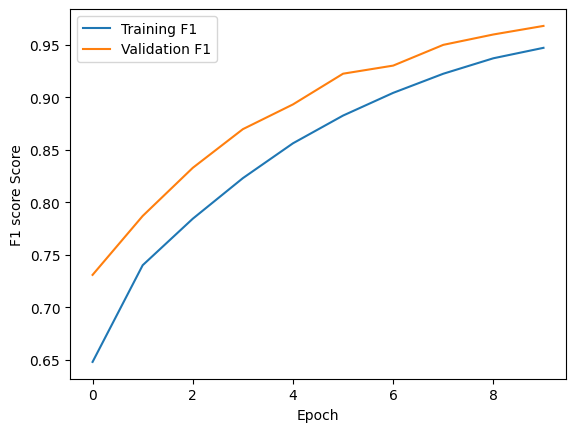

In [ ]:
# Plot the F1 weighted score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 score Score')
plt.legend()
plt.show()

### B. Evaluation

In [ ]:
#
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = model_biLSTM.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 1s 682ms/step


In [ ]:
!pip install sklearn --upgrade 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=f1e822c28acfd71dae81d4ddfa13bbca325ebf2c78f6e547834b576dfab351f5
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [ ]:
import sklearn

RuntimeError: ignored

ImportError: ignored

In [ ]:
# can we adjust threshold ??
from sklearn.metrics import classification_report99
threshold = 0.35
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

## **MODEL II**

### A. GLOVE embeddings

In [ ]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-300')
print("Found %s word vectors." % len(glove.vectors))

[==================================================] 100.0% 376.1/376.1MB downloaded
Found 400000 word vectors.


In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300 ):
    num_tokens = length_voc + 1
    hits = 0
    misses = 0
    oov_embedded = []
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in oov_embedded):
            try: 
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
                hits += 1
            except:
                # handling oovs with random embeddings
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                misses += 1
                oov_embedded.append(word)

    return embedding_matrix, hits, misses, oov_embedded

In [ ]:
# creation of vocabulary for the training set and extraction of his OOVs.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.comment_text)
word_index_train = tokenizer.word_index

print(len(word_index_train.keys()))
embedding_matrix_train, hits, misses, oov_embedded = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
#print(oov_embedded)
print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))
print("Converted %d words (%d misses)" % (hits, misses))

158501
Embedding matrix shape: (158502, 300)
Converted 83674 words (74827 misses)


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, TimeDistributed, GRU
import keras

embedding_layer = Embedding(
    input_dim = embedding_matrix_train.shape[0],
    output_dim = 300,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix_train),
    trainable = False,
    mask_zero = True
)

### B. Architecture

In [ ]:
tf.keras.backend.clear_session()
model_glove = Sequential()
# Create the embedding layer with Glove's embeddings
model_glove.add(embedding_layer)
# Bidirectional LSTM Layer
model_glove.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
# Final layer 
model_glove.add(Dense(6, activation='sigmoid'))

In [ ]:
model_glove.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='weighted', threshold=0.5)])


In [ ]:
model_glove.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         47550600  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 47,991,438
Trainable params: 440,838
Non-trainable params: 47,550,600
_________________________________________________________________


### C. Training

In [ ]:
history = model_glove.fit(train, epochs=10, validation_data=val, callbacks = callbacks)


Epoch 1/10
3989/3989 [==============================] - 157s 39ms/step - loss: 0.0320 - f1_score: 0.8198 - val_loss: 0.0244 - val_f1_score: 0.8752 - lr: 0.0010
Epoch 2/10
3989/3989 [==============================] - 150s 38ms/step - loss: 0.0285 - f1_score: 0.8398 - val_loss: 0.0220 - val_f1_score: 0.8854 - lr: 0.0010
Epoch 3/10
3989/3989 [==============================] - 148s 37ms/step - loss: 0.0260 - f1_score: 0.8537 - val_loss: 0.0193 - val_f1_score: 0.9058 - lr: 0.0010
Epoch 4/10
3989/3989 [==============================] - 155s 39ms/step - loss: 0.0239 - f1_score: 0.8674 - val_loss: 0.0162 - val_f1_score: 0.9226 - lr: 0.0010
Epoch 5/10
3989/3989 [==============================] - 153s 38ms/step - loss: 0.0216 - f1_score: 0.8810 - val_loss: 0.0149 - val_f1_score: 0.9303 - lr: 0.0010
Epoch 6/10
3989/3989 [==============================] - 154s 39ms/step - loss: 0.0202 - f1_score: 0.8895 - val_loss: 0.0127 - val_f1_score: 0.9456 - lr: 0.0010
Epoch 7/10
3989/3989 [==================

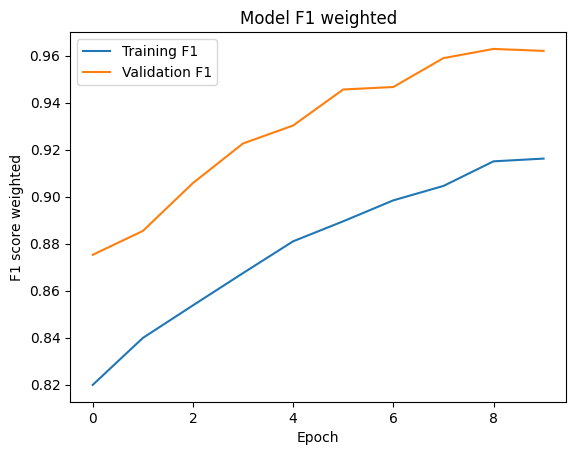

In [ ]:
# Plot the F1 weighted score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.title('Model F1 weighted')
plt.xlabel('Epoch')
plt.ylabel('F1 score weighted')
plt.legend()
plt.show()

### D. Evaluation

In [ ]:

# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = model_glove.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [ ]:
threshold = 0.5
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)